# List of Archives

1. 10, dl380g3 - committee : 50  
2. 20, pc2133  - committee : 50 (first Trial)
3. 20, pc2133  - committee : 10
4. 20, pc2133  - committee : 50
5. 20, dl380g3 - committee : 50
6. 20, dl380g3 - committee : {5, 10, 20, 50, 100, 200} (not finished)
7. 20, dl380g3 - committee : {5, 10, 20, 50, 100, 200} 
8. 20 MicroCloud - committee : 50  duration : {200, 500, 1000,2000,5000} 

In [2]:
import pandas as pd
import re

In [3]:
def getIncrement(x, runs):
    k = 0
    for r in runs: 
        if x < r:
            return k
        k += 1
    return 0

def process_df(nodes, runs, frequency):
    df = pd.DataFrame(nodes, columns=["Nodes", "Succeed", "line"])
    df["Run"] = df.apply(lambda x: runs[getIncrement(x["Nodes"], runs)+x["line"]%(frequency-getIncrement(x["Nodes"], runs))], axis=1)
    df["index_Run"] = df.apply(lambda x: getIncrement(x["Nodes"], runs)+x["line"]%(frequency-getIncrement(x["Nodes"], runs)), axis=1)
    vals = []
    for r in runs:
        dfr = df.loc[df["Run"]==r]
        if df.loc[df["Run"]==r].shape[0] > 0:
            vals.append(dfr.loc[df["Succeed"]==True].shape[0]/r*100)
    return vals, df

def parse_archive(Archive):
    regex_runs = r"^Start run ([0-9]+)"
    runs = []
    regex_nodes = r"^node_([0-9]+),([A-Z][a-z]+)"
    nodes = []
    regex_parameters = r"^Parameters, Committee : ([0-9]+) - Time for registration : ([0-9]+)"
    parameters = []
    nodes_count = {}
    with open("../../simulation/Archive/arch"+str(Archive)+".txt", "r") as f:
        for line in f:
            matches_it = re.finditer(regex_parameters, line)
            matches = [m for m in matches_it]
            if len(matches) == 1:
                groups = matches[0].groups() 
                parameters.append((int(groups[0]), int(groups[1])))
            
            
            matches_it = re.finditer(regex_runs, line)
            matches = [m[1] for m in matches_it]
            if len(matches) == 1:
                runs.append(int(matches[0]))

            matches_it = re.finditer(regex_nodes, line)
            matches = [m for m in matches_it]
            if len(matches) == 1:
                groups = matches[0].groups() 

                num, succeed = int(groups[0]), groups[1]!="False"

                nodes_count[num] = nodes_count.get(num, -1) + 1
                nodes.append((num, succeed, nodes_count[num]))
    
    return nodes, runs, nodes_count, parameters

def get_runs_vals_max_without_repetition(Archive):
    nodes, runs, _, _ = parse_archive(Archive)
    frequency = len(runs)
    vals, _ =  process_df(nodes, runs, frequency)
    return runs, vals

### Experiment 1

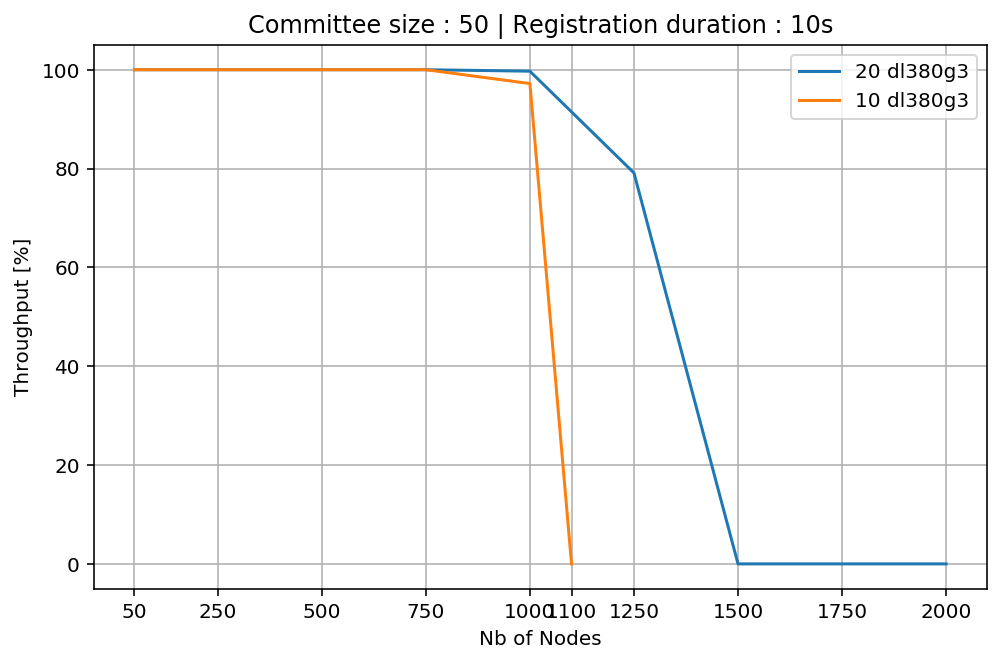

In [4]:
committee = 50
time = 10
Archives = [5, 1] 

frequency = 100

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

ticks = set()
plt.figure(figsize=(8,5))
for a in Archives:
    runs, vals = get_runs_vals_max_without_repetition(a)
    plt.plot(runs, vals)
    ticks = ticks.union(set(runs))
plt.xlabel("Nb of Nodes")
plt.ylabel("Throughput [%]")
plt.xticks(list(ticks))
plt.grid(True)
plt.title("Committee size : "+str(committee)+" | Registration duration : "+str(time)+"s")
plt.legend(["20 dl380g3", "10 dl380g3"])
plt.savefig("Experiment1.1.pdf")
plt.show()

### Experiment 3

[(5, 10000), (10, 10000), (20, 10000), (50, 10000), (100, 10000), (200, 10000)]
[50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 250, 500, 750, 1000, 250, 500, 750, 1000]
5
50 0
250 0
500 0
750 0
1000 0
50 1
250 1
500 1
750 1
1000 1
50 2
250 2
500 2
750 2
1000 2
50 3
250 3
500 3
750 3
1000 3
250 4
500 4
750 4
1000 4
250 5
500 5
750 5
1000 5
[50, 250, 500, 750, 1000] [100.0, 100.0, 100.0, 100.0, 100.0]
[50, 250, 500, 750, 1000] [100.0, 100.0, 100.0, 100.0, 100.0]
[50, 250, 500, 750, 1000] [100.0, 100.0, 100.0, 100.0, 100.0]
[50, 250, 500, 750, 1000] [100.0, 100.0, 100.0, 100.0, 100.0]
[250, 500, 750, 1000] [100.0, 96.8, 57.46666666666667, 0.0]
[250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0]


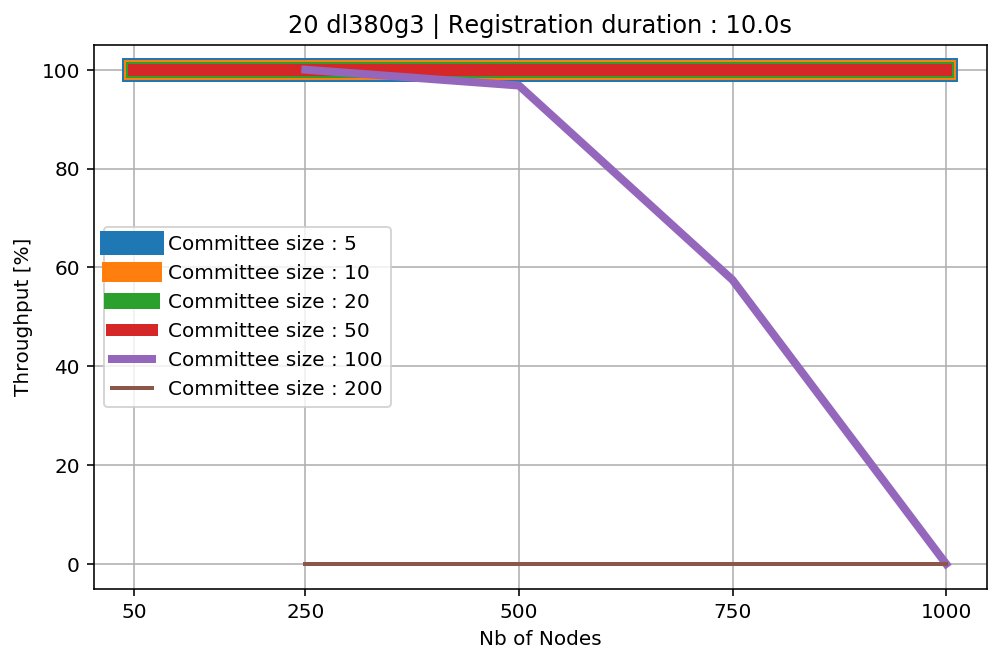

In [63]:
committee = 50
time = 10
Archive = 7

def get_frequency(l):
    seen = []
    for i, e in enumerate(l):
        if e in seen:
            return i
        seen.append(e)
    return len(l)


nodes, runs, _, parameters = parse_archive(Archive)
print(parameters)
print(runs)

frequency = get_frequency(runs)
print(frequency)
_, df =  process_df(nodes, runs, frequency)


vals = [[]]
disp_runs = [[]]
old_r = 0
k=0
for i,r in enumerate(runs):
    if old_r > r:
        vals.append([])
        disp_runs.append([])
        k = k+1
    print(r, k)
    old_r = r
    
    dfr = df.loc[df["Run"]==r]
    nodes_count = {}
    to_drop = []
    for row in dfr.iterrows():
        Nodes = row[1][0]
        nodes_count[Nodes] = nodes_count.get(Nodes, -1) + 1
        if nodes_count[Nodes] != k:
            to_drop.append(row[0])
    dfr = dfr.drop(to_drop)
    vals[-1].append(dfr.loc[df["Succeed"]==True].shape[0]/r*100)
    disp_runs[-1].append(r)
    
for i, (r,v) in enumerate(zip(disp_runs, vals)):
    print(r,v)



%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

ticks = set()
plt.figure(figsize=(8,5))
for i, (r,v) in enumerate(zip(disp_runs, vals)):
    plt.plot(r, v, "-", linewidth=2*len(vals)-2*i)
ticks = ticks.union(set(runs))
plt.xlabel("Nb of Nodes")
plt.ylabel("Throughput [%]")
plt.xticks(list(ticks))
plt.grid(True)
plt.title("20 dl380g3 | Registration duration : "+str(parameters[0][1]/1000)+"s")
plt.legend(["Committee size : "+str(p[0]) for p in parameters])
plt.savefig("Experiment3.pdf")
plt.show()

### Experiment 4

In [34]:
committee = 50
time = 10
Archives = [8,9,10]

def get_frequency(l):
    seen = []
    for i, e in enumerate(l):
        if e in seen:
            return i
        seen.append(e)
    return len(l)


vals = [[]]
disp_runs = [[]]
parameters = []
ticks = set()
for Archive in Archives:
    print("New Archive\n")
    nodes, runs, _, temp_parameters = parse_archive(Archive)
    parameters.extend(temp_parameters)
    print(parameters)
    print(runs)
    ticks = ticks.union(set(runs))
    frequency = get_frequency(runs)
    print(frequency)
    _, df =  process_df(nodes, runs, frequency)

    old_r = 0
    k=0
    for i,r in enumerate(runs):
        if old_r > r:
            vals.append([])
            disp_runs.append([])
            k = k+1
        print(r, k)
        old_r = r

        dfr = df.loc[df["Run"]==r]
        nodes_count = {}
        to_drop = []
        for row in dfr.iterrows():
            Nodes = row[1][0]
            nodes_count[Nodes] = nodes_count.get(Nodes, -1) + 1
            if nodes_count[Nodes] != k:
                to_drop.append(row[0])
        dfr = dfr.drop(to_drop)
        vals[-1].append(dfr.loc[df["Succeed"]==True].shape[0]/r*100)
        disp_runs[-1].append(r)

    for i, (r,v) in enumerate(zip(disp_runs, vals)):
        print(r,v)

    vals.append([])
    disp_runs.append([])



New Archive

[(50, 200), (50, 500), (50, 1000), (50, 2000), (50, 5000)]
[50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000]
5
50 0
250 0
500 0
750 0
1000 0
50 1
250 1
500 1
750 1
1000 1
50 2
250 2
500 2
750 2
1000 2
50 3
250 3
500 3
750 3
1000 3
50 4
250 4
500 4
750 4
1000 4
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [100.0, 13.200000000000001, 0.0, 0.0, 0.0]
New Archive

[(50, 200), (50, 500), (50, 1000), (50, 2000), (50, 5000), (50, 10000), (50, 20000)]
[50, 250, 500, 750, 1000, 50, 250, 500, 750, 1000]
5
50 0
250 0
500 0
750 0
1000 0
50 1
250 1
500 1
750 1
1000 1
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 250, 500, 750, 1000] [0.0, 0.0, 0.0, 0.0, 0.0]
[50, 2

[(50, 200), (50, 500), (50, 1000), (50, 2000), (50, 5000), (50, 10000), (50, 20000), (50, 30000), (50, 20000), (50, 10000)]


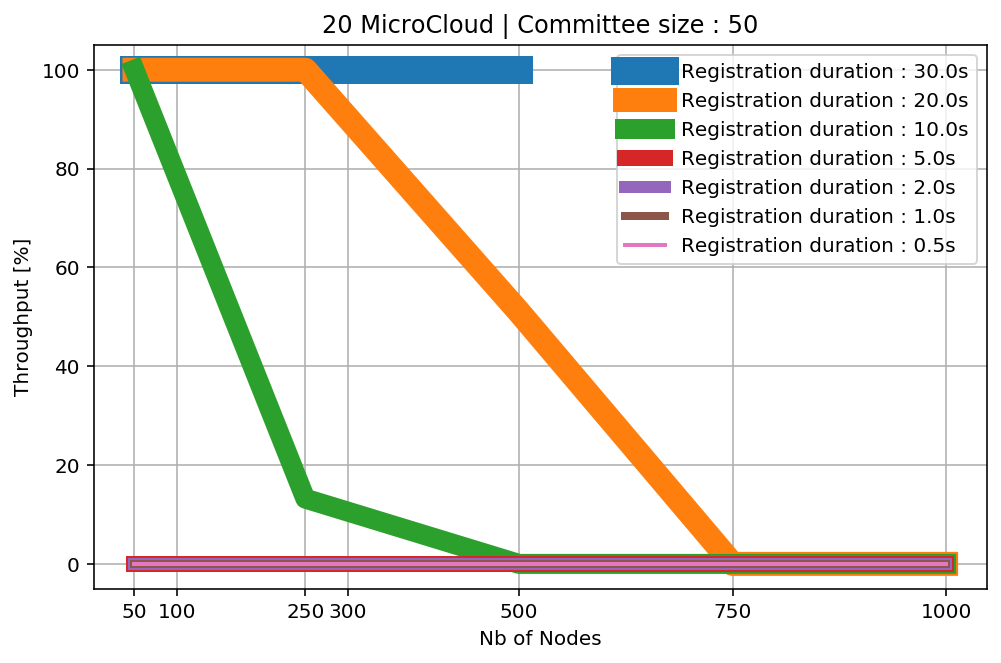

In [35]:
print(parameters)

X = disp_runs[0:6] + disp_runs[7:-3]
Y = vals[0:6]+vals[7:-3]

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for i, (r,v) in enumerate(zip(reversed(X), reversed(Y))):
    plt.plot(r, v, "-", linewidth=2*len(Y)-2*i)
plt.xlabel("Nb of Nodes")
plt.ylabel("Throughput [%]")
plt.xticks(list(ticks))
plt.grid(True)
plt.title("20 MicroCloud | Committee size : "+str(parameters[0][0]))
plt.legend(["Registration duration : "+str(p[1]/1000)+"s" for p in reversed(parameters[:-2])])
plt.savefig("Experiment4.pdf")
plt.show()

# One node point of view

In [ ]:
new_run = "Joined,Epoch"
runs_nodes = []
regex_nodes = r"^node_([0-9]+),"
nodes = []

nodes_count = {}
with open("../../simulation/Data/SignerSetnode_0.txt", "r") as f:
    for line in f:
        if line.strip() == new_run:
            if len(nodes) != 0:
                runs_nodes.append(nodes)
                nodes = []
        else:  
            matches_it = re.finditer(regex_nodes, line)
            matches = [m for m in matches_it]
            
            if len(matches) == 1:
                groups = matches[0].groups() 
                num = int(groups[0])
                nodes.append(num)
runs_nodes.append(nodes)


In [ ]:
print(runs)
print([len(l) for l in runs_nodes])
for r, l in zip(runs, runs_nodes):
    print(len(l)/r)